# 1. Import Libraries

---



In [160]:
# Prep
import pandas as pd
from sklearn.model_selection import train_test_split

# Utility
import numpy as np
from sklearn.gaussian_process.kernels import RBF
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

# 2. Visualize Data

---



In [161]:
df = pd.read_csv("CAD.csv")

In [162]:
numerical_columns = ["Age", "Weight", "BMI", "BP", "PR", "FBS", "CR"]
categorical_columns = ["Sex", "EX-Smoker", "Typical Chest Pain", "Nonanginal", "VHD", "Cath"]

In [163]:
# Categorical Values unique values
print("=="*30)
print(f'Total Categorical Variables = {len(categorical_columns)}')
print("=="*30)
for cat_col in categorical_columns:
  print(f'* {cat_col} ==> {df[cat_col].unique()} ==> {df[cat_col].nunique()} unique values')

Total Categorical Variables = 6
* Sex ==> ['Male' 'Fmale'] ==> 2 unique values
* EX-Smoker ==> [0 1] ==> 2 unique values
* Typical Chest Pain ==> [0 1] ==> 2 unique values
* Nonanginal ==> ['N' 'Y'] ==> 2 unique values
* VHD ==> ['N' 'mild' 'Severe' 'Moderate'] ==> 4 unique values
* Cath ==> ['Cad' 'Normal'] ==> 2 unique values


In [164]:
# Numerical Values
print("=="*30)
print(f'Total Categorical Variables = {len(numerical_columns)}')
print("=="*30)
for num_col in numerical_columns:
  print(f'* {num_col} ==> {df[num_col].min()} - {df[num_col].max()} ==> {df[num_col].max() - df[num_col].min()} range')

Total Categorical Variables = 7
* Age ==> 30 - 86 ==> 56 range
* Weight ==> 48 - 120 ==> 72 range
* BMI ==> 18.11541271 - 40.90065778 ==> 22.785245070000002 range
* BP ==> 90 - 190 ==> 100 range
* PR ==> 50 - 110 ==> 60 range
* FBS ==> 62 - 400 ==> 338 range
* CR ==> 0.5 - 2.2 ==> 1.7000000000000002 range


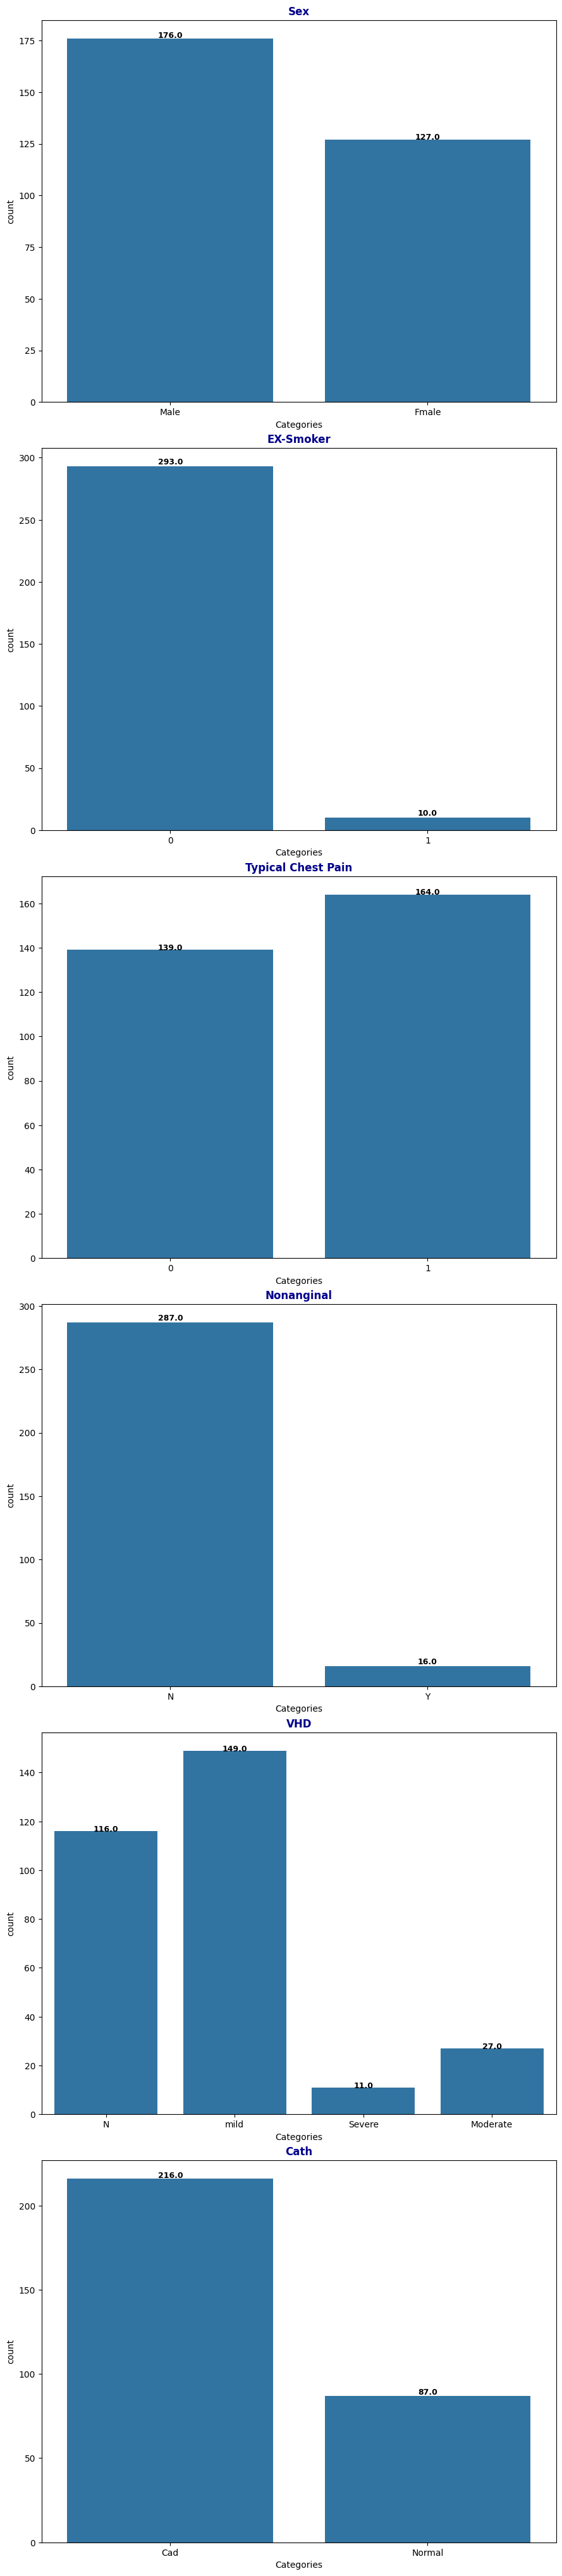

In [165]:
# generate histogram for categorical attributes
fig,ax = plt.subplots(len(categorical_columns),1,figsize = (9,45))
ax = ax.flat

for i,cat_col in enumerate(categorical_columns):
  rects = sns.countplot(df, x = cat_col, ax = ax[i])

  for rect in rects.patches:
      height = rect.get_height()
      ax[i].annotate(f'{height}', (rect.get_x() + rect.get_width() / 2, height-2),
                  xytext=(0, 3),
                  textcoords="offset points",
                  size = 9,
                  ha='center',
                  va='bottom',
                  weight = 'bold')

  ax[i].set_title(f'{cat_col}', fontsize = 12, fontweight = 'bold', color = 'darkblue')
  ax[i].set_xlabel('Categories')


fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

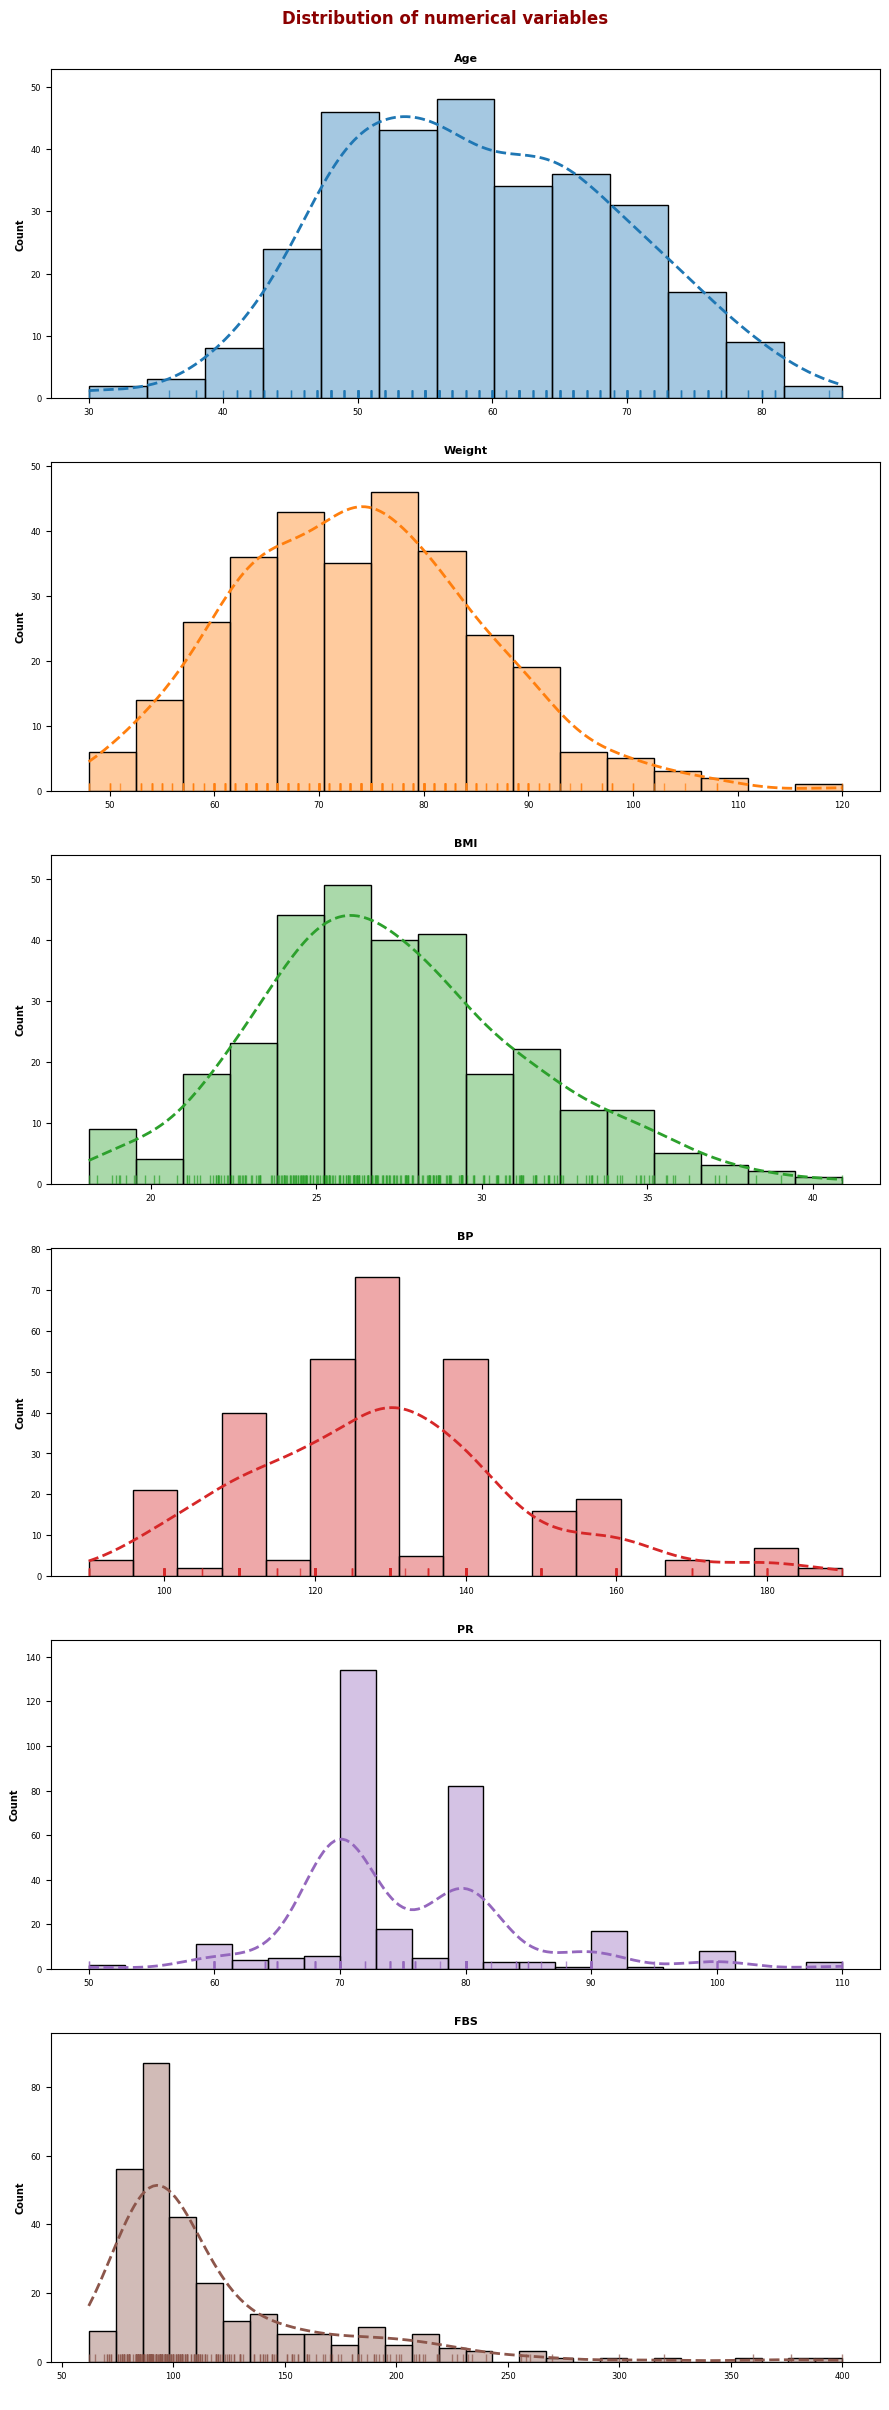

In [166]:
# generate histogram for numerical variables
fig,axes = plt.subplots(nrows = len(numerical_columns), figsize = (9, 30))
axes = axes.flat

color_cycle = list(plt.rcParams['axes.prop_cycle'])
num_colors = len(color_cycle)

for i, num_col in enumerate(numerical_columns):
  sns.histplot(df,
               x = num_col,
               stat = 'count',
               kde = True,
               color = color_cycle[i % num_colors]["color"],
               line_kws = {'linewidth': 2,
                           'linestyle':'dashed'},
               alpha = 0.4,
               ax = axes[i])
  sns.rugplot(df,
              x = num_col,
              color = color_cycle[i % num_colors]["color"],
              ax = axes[i], alpha = 0.7)

  axes[i].set_xlabel(" ")
  axes[i].set_ylabel("Count", fontsize = 7, fontweight = 'bold', color = 'black')
  axes[i].set_title(num_col, fontsize = 8, fontweight = 'bold', color = 'black')
  axes[i].tick_params(labelsize = 6)

fig.delaxes(axes[len(numerical_columns) - 1])
fig.suptitle('Distribution of numerical variables', fontsize = 12, fontweight = 'bold', color = 'darkred', y = 0.92)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

# 3. Preprocess

---



In [167]:
# mappings
# Sex
sex_map = {
    'Male': 0,
    'Fmale': 1,
}
# Yes and No Map
yn_map = {
    'N': 0, 
    'Y': 1,
}
# VHD Map
vhd_map = {
    'N': 0,
    'mild': 1,
    'Moderate': 2,
    'Severe': 3,
}
# Cath Map
cath_map = {
    'Normal': 0,
    'Cad': 1,
}

In [168]:
df['Sex'] = df['Sex'].map(sex_map)
df['Nonanginal'] = df['Nonanginal'].map(yn_map)
df['VHD'] = df['VHD'].map(vhd_map)
df['Cath'] = df['Cath'].map(cath_map)
df

,Age,Weight,Sex,BMI,EX-Smoker,BP,PR,Typical Chest Pain,Nonanginal,FBS,CR,VHD,Cath
0,53,90,0,29.387755,0,110,80,0,0,90,0.7,0,1
1,67,70,1,28.398718,0,140,80,1,0,80,1.0,0,1
2,54,54,0,20.077335,0,100,100,1,0,85,1.0,1,1
3,66,67,1,26.838648,0,100,80,0,1,78,1.2,3,0
4,50,87,1,37.165193,0,110,80,0,0,104,1.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,58,84,0,29.761905,0,100,76,1,0,92,1.0,0,1
299,55,64,1,27.700831,0,100,60,0,0,86,0.9,1,0
300,48,77,1,30.078125,0,130,70,0,1,83,1.0,0,0
301,57,90,1,35.599858,0,100,60,0,0,96,1.0,0,0


In [169]:
## Dat set size
print(f'The data set has {df.shape[0]} rows and {df.shape[1]} columns')
# Generate test and train suites
x_train, x_test, y_VHD_train, y_VHD_test = train_test_split(df.iloc[:, 0:11], df.VHD, test_size=0.2)
_, _, y_cath_train, y_cath_test = train_test_split(df.iloc[:, 0:11], df.Cath, test_size=0.2)

The data set has 303 rows and 13 columns


# 4. Models & Predictions


---



In [170]:
models = {
    'SVC': SVC(),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=5, random_state=0),
    'GaussianNB': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5),
    'AdaBoost': AdaBoostClassifier(),
    'RandomForest': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    'MLPClassifier': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'GaussianProcess': GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis()
}

results_VHD = []
results_Cath = []

for model_name, model_object in models.items():
    # fit model 
    model_VHD = model_object.fit(x_train, y_VHD_train)
    model_Cath = model_object.fit(x_train, y_cath_train)

    predictions_VHD = model_VHD.predict(x_test)
    predictions_Cath = model_Cath.predict(x_test)

    print('-'*60)
    print(f'{model_name} - VHD')
    print(f'accuracy: {accuracy_score(predictions_VHD, y_VHD_test)}')
    print(f'balanced accuracy: {balanced_accuracy_score(predictions_VHD, y_VHD_test)}')
    print('-'*60)
    print(f'{model_name} - Cath')
    print(f'accuracy: {accuracy_score(predictions_Cath, y_cath_test)}')
    print(f'balanced accuracy: {balanced_accuracy_score(predictions_Cath, y_cath_test)}')
    print('-'*60)

    results_VHD.append(balanced_accuracy_score(predictions_VHD, y_VHD_test))
    results_Cath.append(balanced_accuracy_score(predictions_Cath, y_cath_test))

------------------------------------------------------------
SVC - VHD
accuracy: 0.47540983606557374
balanced accuracy: 0.47540983606557374
------------------------------------------------------------
SVC - Cath
accuracy: 0.7213114754098361
balanced accuracy: 0.7213114754098361
------------------------------------------------------------
------------------------------------------------------------
GradientBoosting - VHD
accuracy: 0.36065573770491804
balanced accuracy: 0.28525641025641024
------------------------------------------------------------
GradientBoosting - Cath
accuracy: 0.6721311475409836
balanced accuracy: 0.5673076923076923
------------------------------------------------------------
------------------------------------------------------------
GaussianNB - VHD
accuracy: 0.4098360655737705
balanced accuracy: 0.23148148148148148
------------------------------------------------------------
GaussianNB - Cath
accuracy: 0.7377049180327869
balanced accuracy: 0.6653439153439153
--


# 5. Results

---

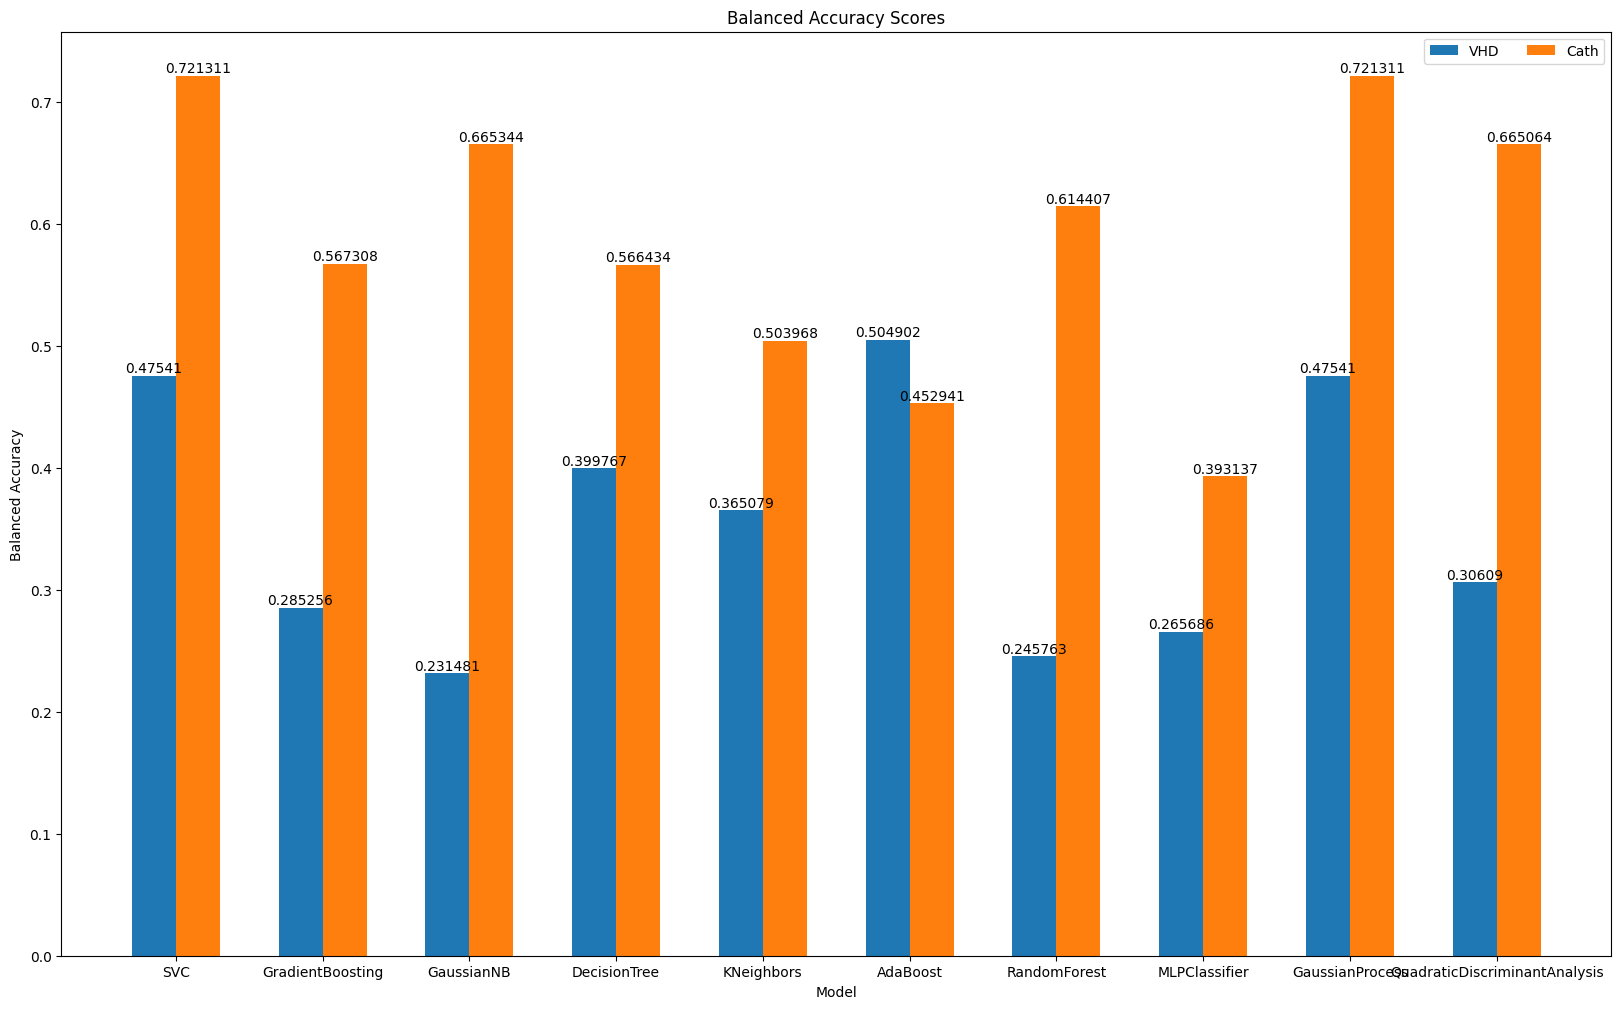

In [171]:
x_axis = list(models.keys())
y_axis = {
    'VHD': results_VHD,
    'Cath': results_Cath
}

x = np.arange(len(x_axis))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0


fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(20)

for attribute, measurement in y_axis.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=0)

    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Balanced Accuracy')
ax.set_xlabel('Model')
ax.set_title('Balanced Accuracy Scores')
ax.set_xticks(x + width/2, x_axis)
ax.legend(loc='best', ncols=2)

plt.show()